# Multi-head attention

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# below code ecplaniation
* sequence_length:- it is the length of my input sentence and it typically use a max sequence lenth so that all of our vectors are going to be fixed size . 
* batch_size:- it helps us for parallel processing , in this case we are going to use 1.
* input_dim:- this is input dimention , which is the vector dimention of every word that goes into the attention unit.
* d_model:- it is for the output of the attention unit for every single word

In [2]:
sequence_length=4
batch_size=1
input_dim=512
d_model=512
x=torch.randn((batch_size,sequence_length,input_dim))

In [3]:
x.size()

torch.Size([1, 4, 512])

In [4]:
# now we are going to mapp this input dimention with 3 times d_model dimention
qkv_layer=nn.Linear(input_dim,3*d_model)

In [5]:
qkv=qkv_layer(x)

In [6]:
qkv.shape

torch.Size([1, 4, 1536])

[]

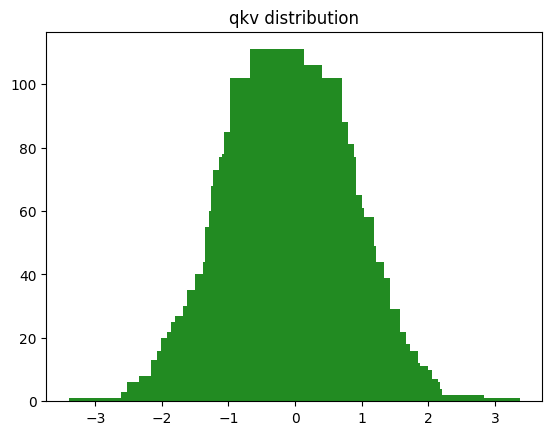

In [7]:
# now ploting these word representation 
import matplotlib.pyplot as plt
y_val=torch.histc(qkv,bins=200,min=3,max=3)
x_val=np.arange(-1,1,0.01)*3
plt.bar(x_val,y_val,align='center',color=['forestgreen'])
plt.title('qkv distribution')
plt.plot()

In [38]:
num_head=8 # 8 attention head
head_dim=d_model//num_head
qkv=qkv.reshape(batch_size,sequence_length,num_head,3*head_dim)

In [9]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [10]:
qkv=qkv.permute(0,2,1,3) # [batch_size,num_heads,sequence_length,3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [11]:
# getting the seprate query,key and value vectors by dividing the lasy vector with 192
q,k,v=qkv.chunk(3,dim=-1)
q.shape,k.shape,v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [12]:
# now we are going to perfrom the attention mechanism by applying its formuale


In [13]:
d_k=q.size()[-1]
scaled=torch.matmul(q,k.transpose(-2,-1))/math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [14]:
k.T.shape

C:\Users\rajkr\AppData\Local\Temp\ipykernel_10180\3717780648.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3679.)
  k.T.shape


torch.Size([64, 4, 8, 1])

In [15]:
y=torch.randn(2,3)
torch.transpose(y,0,1)

tensor([[ 0.0307,  0.5635],
        [-1.4079, -0.8375],
        [-0.8716,  0.6841]])

In [16]:
torch.transpose(y,1,0)

tensor([[ 0.0307,  0.5635],
        [-1.4079, -0.8375],
        [-0.8716,  0.6841]])

In [17]:
k.transpose(-1,-2)==k.transpose(-2,-1)

tensor([[[[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         ...,

         [[True, True, True, True],
          [True, True, True, True],
          [True, True, True, True],
          ...,
          [True, True, True, True],
          [True, True, True, True],
          [True, True, True, True]],

         [[True, True, True, True],
          [True, 

# applying masking in decoder 

In [19]:
mask=torch.full(scaled.size(),float('-inf'))
mask=torch.triu(mask,diagonal=1)
mask[0][1] # mask for input to a singal head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [20]:
(scaled+mask)[0][0]

tensor([[-0.2099,    -inf,    -inf,    -inf],
        [-0.3833, -0.5330,    -inf,    -inf],
        [ 0.0624, -0.0831, -0.1685,    -inf],
        [-0.1492, -0.3380, -0.4372, -0.1259]], grad_fn=<SelectBackward0>)

In [21]:
scaled+=mask

In [22]:
np.exp(0.5596)/(np.exp(0.5596)+np.exp(0.0404))

0.6269606805367254

In [28]:
#Applying the softmax
attention=F.softmax(scaled,dim=1)

In [24]:
attention.shape

torch.Size([1, 8, 4, 4])

In [25]:
attention[0][0]

tensor([[0.0835,    nan,    nan,    nan],
        [0.0931, 0.0729,    nan,    nan],
        [0.1743, 0.1032, 0.1140,    nan],
        [0.1063, 0.0959, 0.0617, 0.0878]], grad_fn=<SelectBackward0>)

In [29]:
values=torch.matmul(attention,v)
values.shape

torch.Size([1, 8, 4, 64])

In [30]:
# Function :- whatever we done above , we build a fucntion for thhat task

In [31]:
def scaled_dot_product(q,k,v,mask=None):
    d_k=q.size()[-1]
    scaled=torch.matmul(q,k.transpose(-1,-2))/math.sqrt(d_k)
    if mask is not None:
        scaled+=mask
    attention=F.softmax(scaled,dim=1)
    values=torch.matmul(attention,v)
    return values,attention

In [32]:
values,attention=scaled_dot_product(q,k,v,mask=None)

In [33]:
attention.shape

torch.Size([1, 8, 4, 4])

In [34]:
attention[0][0]

tensor([[0.0835, 0.1212, 0.1839, 0.0989],
        [0.0931, 0.0729, 0.1036, 0.1273],
        [0.1743, 0.1032, 0.1140, 0.1180],
        [0.1063, 0.0959, 0.0617, 0.0878]], grad_fn=<SelectBackward0>)

In [36]:
values.size()

torch.Size([1, 8, 4, 64])

In [40]:
values=values.reshape(batch_size,sequence_length,num_head*head_dim)

In [41]:
values.size()

torch.Size([1, 4, 512])

In [42]:
linear_layer = nn.Linear(d_model, d_model)

In [43]:
out = linear_layer(values)

In [44]:
out.shape

torch.Size([1, 4, 512])

In [45]:
torch.Size([1, 4, 512])

torch.Size([1, 4, 512])

In [46]:
out

tensor([[[-4.4459e-02, -7.4631e-02, -3.2726e-02,  ...,  7.2160e-02,
          -1.0926e-01, -5.8359e-02],
         [-3.9074e-02, -4.4827e-02,  7.6396e-03,  ...,  5.1896e-02,
           7.9540e-02,  1.8148e-02],
         [ 1.7580e-01,  4.2266e-02,  7.2121e-03,  ...,  9.1686e-02,
          -1.1138e-01, -5.6070e-02],
         [ 2.7691e-02, -1.2904e-01,  1.2023e-04,  ...,  2.0774e-01,
          -9.6309e-02, -3.1254e-02]]], grad_fn=<ViewBackward0>)

# 
Class

In [47]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention


class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out

# Input

In [48]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
